In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [8]:


# Read the data
df = pd.read_csv('./data/multi_tcp_20250411064307.csv', sep=';')
df.head(10)




,wscale,rto,rtt,mss,pmtu,rcvmss,advmss,cwnd,ssthresh,bytes_sent,...,segs_out,segs_in,data_segs_out,lastrcv,delivered,rcv_space,rcv_ssthresh,loss_ratio,tcp_type,timestamp
0,9.0,3996,1332.000,1448,1500,536,1448,10,42242,14481,...,13,1,10,252,0,14480,42242,0.000069,reno,0
1,9.0,256,53.300,1448,1500,536,1448,20,7,1954801,...,1373,724,1369,3928,0,14480,42242,0.000010,reno,2
2,9.0,260,59.750,1448,1500,536,1448,8,3,2658529,...,1870,970,1866,6472,0,14480,42242,0.000011,reno,4
3,9.0,256,52.860,1448,1500,536,1448,18,14,3953041,...,2772,1386,2768,9632,0,14480,42242,0.000010,reno,6
4,9.0,264,60.162,1448,1500,536,1448,12,12,5350361,...,3747,1823,3743,12932,0,14480,42242,0.000009,reno,8
5,9.0,256,54.555,1448,1500,536,1448,12,8,6750577,...,4724,2269,4720,16080,0,14480,42242,0.000009,reno,10
6,9.0,264,63.059,1448,1500,536,1448,17,3,7390593,...,5176,2481,5172,18796,0,14480,42242,0.000009,reno,12
7,9.0,264,60.615,1448,1500,536,1448,12,10,8224641,...,5765,2764,5761,21616,0,14480,42242,0.000010,reno,14
8,9.0,260,57.901,1448,1500,536,1448,6,6,9467025,...,6635,3155,6631,24612,0,14480,42242,0.000010,reno,16
9,9.0,256,53.302,1448,1500,536,1448,5,5,10558817,...,7399,3522,7395,27712,0,14480,42242,0.000010,reno,18


(0.0, 41.800000000000004)

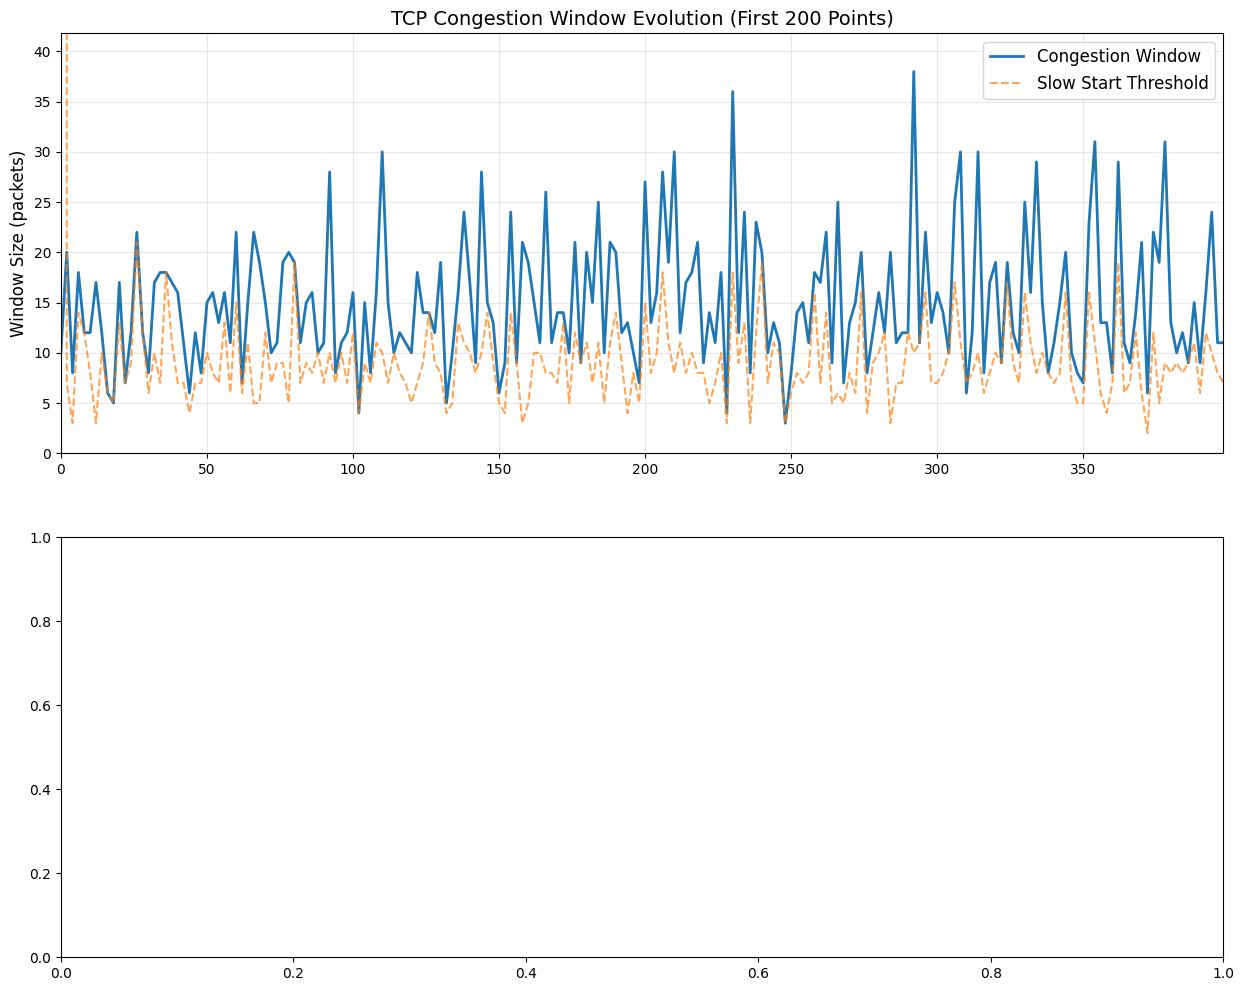

In [ ]:
# Slice the first 200 rows
df_subset = df.iloc[:200]

# Create a figure with multiple subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot congestion window and slow start threshold
ax1.plot(df_subset['timestamp'], df_subset['cwnd'], label='Congestion Window', linewidth=2)
ax1.plot(df_subset['timestamp'], df_subset['ssthresh'], label='Slow Start Threshold', linestyle='--', alpha=0.7)
ax1.set_title('TCP Congestion Window Evolution (First 200 Points)', fontsize=14)
ax1.set_ylabel('Window Size (packets)', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=12)
ax1.set_xlim(df_subset['timestamp'].min(), df_subset['timestamp'].max())
ax1.set_ylim(0, df_subset['cwnd'].max() * 1.1)







Reno average cwnd: 27.976944444444445
Cubic average cwnd: 30.656111111111112


/var/folders/46/zfgqyys5331br5_jg4gtn6vc0000gn/T/ipykernel_16759/2705000023.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sliced_reno_df['timestamp'] = sliced_reno_df.index
/var/folders/46/zfgqyys5331br5_jg4gtn6vc0000gn/T/ipykernel_16759/2705000023.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sliced_cubic_df['timestamp'] = sliced_cubic_df.index


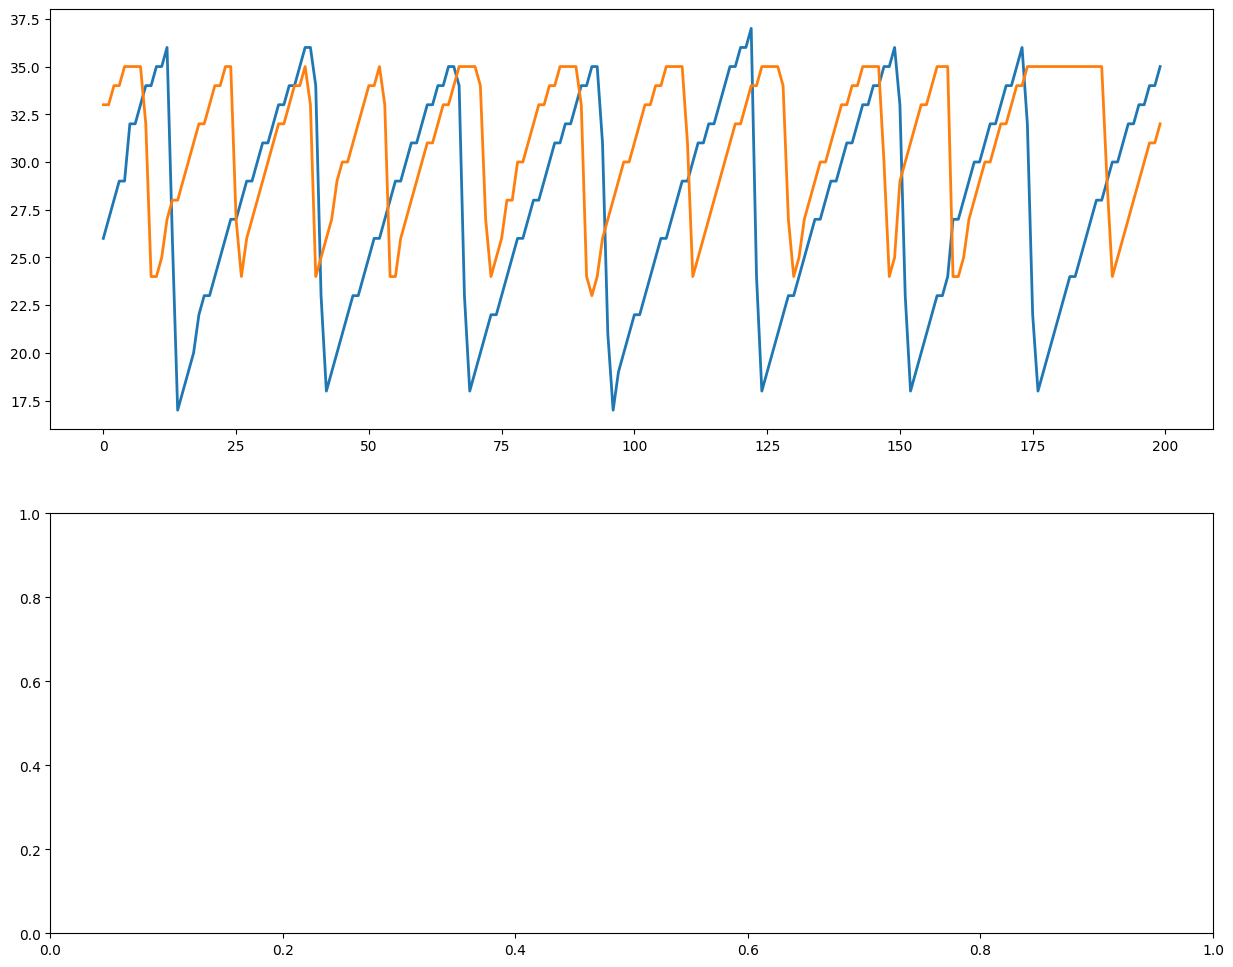

In [17]:
# reno and cubic data

reno_file_path = "../reno1.log.csv"

reno_df = pd.read_csv(reno_file_path, delimiter =";")

cubic_file_path = "../cubic1.log.csv"

cubic_df = pd.read_csv(cubic_file_path, delimiter=";")

# plot the cwnd for first 200 points

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# theres no timestamp column in the reno and cubic data
# use the index as the timestamp

sliced_reno_df = reno_df.iloc[:200]
sliced_cubic_df = cubic_df.iloc[:200]
sliced_reno_df['timestamp'] = sliced_reno_df.index
sliced_cubic_df['timestamp'] = sliced_cubic_df.index
ax1.plot(sliced_reno_df['timestamp'], sliced_reno_df['cwnd'], label='Reno', linewidth=2)
ax1.plot(sliced_cubic_df['timestamp'], sliced_cubic_df['cwnd'], label='Cubic', linewidth=2)

# average the cwnd for the reno and cubic data

reno_avg_cwnd = reno_df['cwnd'].mean()
cubic_avg_cwnd = cubic_df['cwnd'].mean()

print(f"Reno average cwnd: {reno_avg_cwnd}")
print(f"Cubic average cwnd: {cubic_avg_cwnd}")
